In [1]:
## Import Libraries
import sys

import numpy as np
import pandas as pd
import scipy

from matplotlib import pyplot as plt

import torch
from torch import nn
from torchvision import datasets, transforms

source = "../source"
sys.path.append(source)

from preprocessing import Direct
from compilation import Compiler, ScalarTracker, ActivationTracker
import publication
import models
import simulate

device = torch.device("cpu")

plot_path = "plots/mnist/"

save = True

In [2]:
## Load the data
encoding = Direct()
input_size = 28 * 28
output_size = 10

input_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(torch.ravel),
        transforms.Lambda(lambda x: x.to(device)),
    ]
)
output_transforms = transforms.Lambda(
    lambda y: torch.zeros(10, dtype=torch.float)
    .scatter_(0, torch.tensor(y), value=1)
    .to(device)
)

train_data = datasets.MNIST(
    "./data/MNIST",
    train=True,
    download=True,
    transform=input_transforms,
    target_transform=output_transforms,
)
val_data = datasets.MNIST(
    "./data/MNIST",
    train=False,
    download=True,
    transform=input_transforms,
    target_transform=output_transforms,
)

train_datasets = [torch.utils.data.Subset(train_data, np.arange(60000))]
tracked_datasets = [val_data] + train_datasets

labels = np.array([np.argmax(y.cpu()) for x, y in train_datasets[0]])

# analyzed_data = torch.utils.data.Subset(train_data, np.arange(60000))


# random_0s = [np.random.choice(np.arange(60000)[labels == 0]) for _ in range(10)]
# random_1s = [np.random.choice(np.arange(60000)[labels == 1]) for _ in range(10)]

# tracked_points = torch.utils.data.Subset(train_data, random_0s + random_1s)

random_0 = np.random.choice(np.arange(60000)[labels == 0])
random_1 = np.random.choice(np.arange(60000)[labels == 1])
two_points = torch.utils.data.Subset(train_data, [random_0, random_1])

In [3]:
## Load settings
settings = "trajectories"

(
    model_type,
    nonlinearity,
    gain,
    lr,
    P,
    L,
    n_epochs,
    hidden_layer,
    dx2,
    dy2,
    in_dim,
    out_dim,
) = (
    pd.read_csv("model_settings/mnist.txt", sep=" ", header=0).loc[settings].to_numpy()
)
model_type = getattr(models, model_type)
nonlinearity = getattr(torch.nn.functional, nonlinearity)

In [4]:
## Instantiate model
model = model_type(
    encoding=encoding,
    input_size=input_size,
    output_size=output_size,
    hidden_dim=P,
    n_hid_layers=L,
    device=device,
    init_std=gain,
)

In [5]:
## Setup compiler
criterion = lambda x, y: 0.5 * nn.functional.mse_loss(x, y)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
compiler = Compiler(model, criterion, optimizer)
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    "hidden": ActivationTracker(
        model,
        lambda inputs: model(inputs)[1][int(len(model) / 2)],
        datasets=[two_points],
    ),
    "output": ActivationTracker(
        model, lambda inputs: model(inputs)[0], datasets=[two_points]
    ),
}

In [6]:
## Training run
compiler.training_run(train_datasets, n_epochs=n_epochs, batch_size=64)

Training: 100%|██████████| 200/200 [1:00:27<00:00, 18.14s/steps, train_loss=0.00749, val_loss=0.00730]


In [7]:
# ## Get data
# data_hid = compiler.trackers["hidden"].get_trace()
# data_output = compiler.trackers["output"].get_trace()
# loss = compiler.trackers["loss"].get_trace()
# val_loss = loss.query("Dataset==0")[0].to_numpy()
# train_loss = loss.query("Dataset>0").groupby("Epoch").mean()

# n = len(data_hid.query("Epoch==0"))

# for i in range(0, n - 1, 2):
#     index_A, index_B = (
#         np.argmax(two_points[i][1]).item(),
#         np.argmax(two_points[i + 2][1]).item(),
#     )
#     if index_A == index_B:
#         continue

#     cond_A = np.zeros(n, dtype=bool)
#     cond_B = np.zeros(n, dtype=bool)
#     cond_A[i] = True
#     cond_B[i + 2] = True

#     h_A = [
#         np.mean(np.array(data[cond_A].loc[epoch, 0, :]), axis=0)
#         for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
#     ]
#     y_A = [
#         np.mean(np.array(data[cond_A].loc[epoch, 0, :]), axis=0)
#         for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
#     ]
#     y_true_A = np.mean(np.array([y.numpy() for x, y in two_points])[cond_A], axis=0)
#     N_A = np.sum(cond_A)
#     h_B = [
#         np.mean(np.array(data[cond_B].loc[epoch, 0, :]), axis=0)
#         for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
#     ]
#     y_B = [
#         np.mean(np.array(data[cond_B].loc[epoch, 0, :]), axis=0)
#         for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
#     ]
#     y_true_B = np.mean(np.array([y.numpy() for x, y in two_points])[cond_B], axis=0)
#     N_B = np.sum(cond_B)

#     epochs = np.arange(0, len(h_A))
#     dy2 = np.sum((y_true_B - y_true_A) ** 2)
#     h2 = np.array([np.sum((h_A[epoch] - h_B[epoch]) ** 2) for epoch in epochs])
#     y2 = np.array([np.sum((y_A[epoch] - y_B[epoch]) ** 2) for epoch in epochs])
#     w = np.array(
#         [
#             y2[epoch] - np.dot(y_true_A - y_true_B, y_A[epoch] - y_B[epoch])
#             for epoch in epochs
#         ]
#     )
#     y0_mean = np.sum((0.5 * ((y_A[0] + y_B[0]) - (y_true_B + y_true_A))) ** 2)
#     dx2 = np.linalg.norm(two_points[0][0] - two_points[1][0]) ** 2

#     h0, y0, w0, dy = h2[0], y2[0], w[0], dy2

#     ## Fit theory
#     max_epoch = len(epochs)

#     eta_h_opt, eta_y_opt, _ = simulate.optimize_eta(
#         h2[:max_epoch],
#         y2[:max_epoch],
#         w[:max_epoch],
#         dx2,
#         dy2,
#         guesses=np.logspace(-6, 1, 100),
#     )
#     eta_h, eta_y = np.array((eta_h_opt, eta_y_opt))

#     t_max = len(epochs)

#     sol = scipy.integrate.solve_ivp(
#         simulate.der,
#         [0, t_max],
#         np.array([h0, y0, w0]),
#         args=(eta_h, eta_y, dx2, dy2),
#         dense_output=True,
#         method="Radau",
#     )

#     t = np.linspace(0, t_max, len(epochs))
#     z = sol.sol(t)
#     z = z[:, :max_epoch]
#     t = epochs[:max_epoch]

#     ## Plot dynamics
#     c = 0.1

#     publication.set_color_mixed()
#     fig, ax = plt.subplots(figsize=(4, 3))
#     plt.plot(t, c * z[0], linestyle="--")
#     plt.plot(t, z[1], linestyle="--")
#     plt.plot(t, z[2], linestyle="--")
#     plt.gca().set_prop_cycle(None)
#     ax.plot(t, c * h2[:max_epoch], label="$||dh||^2$")
#     ax.plot(t, y2[:max_epoch], label="$||dy||^2$")
#     ax.plot(t, w[:max_epoch], label="$w$")
#     plt.xlabel("Epochs")
#     publication.plt_show()

In [11]:
## Get data
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()
loss = compiler.trackers["loss"].get_trace()
val_loss = loss.query("Dataset==0")[0].to_numpy()
train_loss = loss.query("Dataset>0").groupby("Epoch").mean()

# cond_A = np.zeros(2, dtype=bool)
# cond_B = np.zeros(2, dtype=bool)
# cond_A[0] = True
# cond_B[1] = True

cond_A = np.zeros(len(data_hid.query("Epoch==0")), dtype=bool)
cond_B = np.zeros(len(data_hid.query("Epoch==0")), dtype=bool)
cond_A[0] = True
cond_B[1] = True

h_A = [
    np.mean(np.array(data[cond_A].loc[epoch, 0, :]), axis=0)
    for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
]
y_A = [
    np.mean(np.array(data[cond_A].loc[epoch, 0, :]), axis=0)
    for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
]
y_true_A = np.mean(np.array([y.numpy() for x, y in two_points])[cond_A], axis=0)
N_A = np.sum(cond_A)
h_B = [
    np.mean(np.array(data[cond_B].loc[epoch, 0, :]), axis=0)
    for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
]
y_B = [
    np.mean(np.array(data[cond_B].loc[epoch, 0, :]), axis=0)
    for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
]
y_true_B = np.mean(np.array([y.numpy() for x, y in two_points])[cond_B], axis=0)
N_B = np.sum(cond_B)

epochs = np.arange(0, len(h_A))
dy2 = np.sum((y_true_B - y_true_A) ** 2)
h2 = np.array([np.sum((h_A[epoch] - h_B[epoch]) ** 2) for epoch in epochs])
y2 = np.array([np.sum((y_A[epoch] - y_B[epoch]) ** 2) for epoch in epochs])
w = np.array(
    [
        y2[epoch] - np.dot(y_true_A - y_true_B, y_A[epoch] - y_B[epoch])
        for epoch in epochs
    ]
)
y0_mean = np.sum((0.5 * ((y_A[0] + y_B[0]) - (y_true_B + y_true_A))) ** 2)
dx2 = np.linalg.norm(two_points[0][0] - two_points[1][0]) ** 2

h0, y0, w0, dy = h2[0], y2[0], w[0], dy2

In [12]:
## Fit theory
max_epoch = len(epochs)

eta_h_opt, eta_y_opt, _ = simulate.optimize_eta(
    h2[:max_epoch],
    y2[:max_epoch],
    w[:max_epoch],
    dx2,
    dy2,
    guesses=np.logspace(-6, 1, 100),
)
eta_h, eta_y = np.array((eta_h_opt, eta_y_opt))


t_max = len(epochs)

sol = scipy.integrate.solve_ivp(
    simulate.der,
    [0, t_max],
    np.array([h0, y0, w0]),
    args=(eta_h, eta_y, dx2, dy2),
    dense_output=True,
    method="Radau",
)

t = np.linspace(0, t_max, len(epochs))
z = sol.sol(t)
z = z[:, :max_epoch]
t = epochs[:max_epoch]

Loss: 323.91443863995374


FileNotFoundError: [Errno 2] No such file or directory: 'plots/mnist/trajectory/trajectories.png'

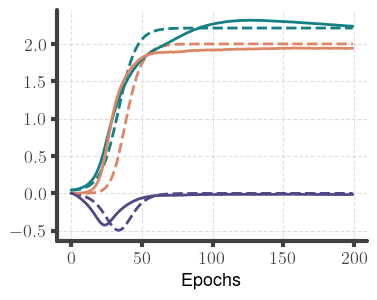

In [13]:
## Plot dynamics
c = 0.1


publication.set_color_mixed()
fig, ax = plt.subplots(figsize=(4, 3))
plt.plot(t, c * z[0], linestyle="--")
plt.plot(t, z[1], linestyle="--")
plt.plot(t, z[2], linestyle="--")
plt.gca().set_prop_cycle(None)
ax.plot(t, c * h2[:max_epoch], label="$||dh||^2$")
ax.plot(t, y2[:max_epoch], label="$||dy||^2$")
ax.plot(t, w[:max_epoch], label="$w$")
# ax.legend()
plt.xlabel("Epochs")
if save:
    publication.plt_show(save_path=plot_path + "trajectory/" + settings)
else:
    publication.plt_show()

In [ ]:
## Compute validation accuracy
correct_count = 0
for x, y in val_data:
    prediction = torch.argmax(model(x)[0])
    true_digit = torch.argmax(y)
    if prediction == true_digit:
        correct_count += 1
fraction_correct = correct_count / len(val_data)
print(f"Validation accuracy: {fraction_correct}")

Validation accuracy: 0.8744
